# Sentinel-2 snow cover area (SCA) time series

This notebook will show how to generate a snow cover area time series for a given catchment of interest from Sentinel-2 images.

### Importing dependencies

In [1]:
# xcube_sh imports
from xcube_sh.cube import open_cube
from xcube_sh.config import CubeConfig
from xcube_sh.sentinelhub import SentinelHub

# xcube imports
from xcube.core.geom import mask_dataset_by_geometry

# Various utilities
from datetime import date
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import folium

### Select a region of interest

Load and visualize a test catchment outline which will be used as a reogion of interest in this example

In [2]:
catchment_outline = gpd.read_file('catchment_outline.geojson')

In [3]:
m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
folium.GeoJson(data=catchment_outline.to_json(), name='catchment').add_to(m)
m

/tmp/ipykernel_72/1928884253.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])
/tmp/ipykernel_72/1928884253.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[catchment_outline.centroid.y, catchment_outline.centroid.x])


### Configuring the data content of the cube

We need to set the following configuration input variable to define the content of the data cube we want to access
- dataset name
- band names
- time range
- the area of interest specifed via bounding box coordinates
- spatial resolution

To select the correct dataset we can first list all the available dataset:

In [4]:
SH = SentinelHub()
SH.dataset_names

['LETML1',
 'LOTL1',
 'LETML2',
 'CUSTOM',
 'LMSSL1',
 'LTML2',
 'LOTL2',
 'S3OLCI',
 'S3SLSTR',
 'DEM',
 'MODIS',
 'S5PL2',
 'HLS',
 'LTML1',
 'S1GRD',
 'S2L2A',
 'S2L1C']

We want to use the Sentinel-2 L2A product. Then the configuration variable `dataset_name` can be set equal to `'S2L2A'`. 

Then we can visualize all the bands for the S2L2A dataset (the documentation to this dataset can be read at https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/):

In [5]:
SH.band_names('S2L2A')

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B11',
 'B12',
 'SCL',
 'SNW',
 'CLD',
 'viewZenithMean',
 'viewAzimuthMean',
 'sunZenithAngles',
 'sunAzimuthAngles',
 'AOT',
 'CLM',
 'CLP']

As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018:

In [12]:
start_date = date(2018, 2, 1)
end_date = date(2018, 6, 30)

Now we need to extract the bounding box of the catchment outline, which will be used to access the needed Sentinel-2 data in our region of interest

In [13]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

### Create a Sentinel-2 RGB 

As a first step we will create a RGB data cube from Sentinel-2, including a cloud cover map (CLM). This can be useful to visualize the Sentinel-2 images for some specific date. The spatial resolution set for this cube will be 0.00018 degree, which correspond roughly to the native 10 meter resolution of the Sentinel-2 visible bands (B02: blue, B03: green, B04: red)

In [14]:
cube_config_s2rgb = CubeConfig(
    dataset_name='S2L2A',
    band_names=['B02', 'B03', 'B04', 'CLM'],
    bbox=bbox.tolist(),
    spatial_res=0.00018,
    time_range=[start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")]
)

/home/conda/master-asi-conae/315434deb1b1e05eacacc41e1b0529b1837100f46402a32041d77ba54ae6c5f3-20230213-125825-013239-74-edc-2022.10-14/lib/python3.9/site-packages/xcube_sh/config.py:248: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


Loading the data into the cube

In [15]:
cube_s2rgb = open_cube(cube_config_s2rgb)
cube_s2rgb

<xarray.Dataset>
Dimensions:    (time: 58, lat: 1864, lon: 2146, bnds: 2)
Coordinates:
  * lat        (lat) float64 46.99 46.99 46.99 46.99 ... 46.65 46.65 46.65 46.65
  * lon        (lon) float64 11.02 11.02 11.02 11.02 ... 11.41 11.41 11.41 11.41
  * time       (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T10:13:58
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B02        (time, lat, lon) float32 dask.array<chunksize=(1, 932, 1073), meta=np.ndarray>
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 932, 1073), meta=np.ndarray>
    B04        (time, lat, lon) float32 dask.array<chunksize=(1, 932, 1073), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 932, 1073), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-02-21T09:43:08.149994
    time_coverage_start:     2018-02-01T10:22:37+00:00
    time_coverage_end:       2018-06-28T10:13:58+00:00
    time_coverage_duration:  P146DT23H51M21S
    geospatial_lon_min:      11.020833333333357
    geospatial_lat_min:      46.653599378797765
    geospatial_lon_max:      11.407113333333356
    geospatial_lat_max:      46.98911937879777
    processing_level:        L2A

Show the date list of the data in the cube

In [16]:
cube_s2rgb.time

<xarray.DataArray 'time' (time: 58)>
array(['2018-02-01T10:22:37.000000000', '2018-02-03T10:12:37.000000000',
       '2018-02-06T10:22:06.000000000', '2018-02-08T10:11:53.000000000',
       '2018-02-11T10:25:59.000000000', '2018-02-13T10:15:59.000000000',
       '2018-02-16T10:26:01.000000000', '2018-02-18T10:13:13.000000000',
       '2018-02-21T10:20:33.000000000', '2018-02-23T10:15:08.000000000',
       '2018-02-26T10:20:50.000000000', '2018-02-28T10:10:21.000000000',
       '2018-03-03T10:27:07.000000000', '2018-03-05T10:13:15.000000000',
       '2018-03-08T10:22:41.000000000', '2018-03-10T10:10:20.000000000',
       '2018-03-13T10:25:40.000000000', '2018-03-15T10:10:38.000000000',
       '2018-03-20T10:10:21.000000000', '2018-03-23T10:20:21.000000000',
       '2018-03-25T10:15:11.000000000', '2018-03-28T10:23:58.000000000',
       '2018-03-30T10:16:20.000000000', '2018-04-02T10:24:35.000000000',
       '2018-04-04T10:10:21.000000000', '2018-04-07T10:20:20.000000000',
       '2018-04-09T10:13:43.000000000', '2018-04-12T10:20:24.000000000',
       '2018-04-14T10:15:36.000000000', '2018-04-17T10:20:21.000000000',
       '2018-04-19T10:14:57.000000000', '2018-04-22T10:21:15.000000000',
       '2018-04-24T10:15:26.000000000', '2018-04-27T10:20:22.000000000',
       '2018-04-29T10:12:58.000000000', '2018-05-02T10:24:34.000000000',
       '2018-05-04T10:10:23.000000000', '2018-05-07T10:26:48.000000000',
       '2018-05-09T10:16:21.000000000', '2018-05-12T10:21:48.000000000',
       '2018-05-14T10:10:52.000000000', '2018-05-17T10:22:09.000000000',
       '2018-05-19T10:12:07.000000000', '2018-05-22T10:20:25.000000000',
       '2018-05-24T10:10:22.000000000', '2018-05-29T10:12:25.000000000',
       '2018-06-01T10:20:24.000000000', '2018-06-03T10:13:29.000000000',
       '2018-06-06T10:25:12.000000000', '2018-06-08T10:17:26.000000000',
       '2018-06-11T10:26:34.000000000', '2018-06-13T10:14:24.000000000',
       '2018-06-16T10:20:21.000000000', '2018-06-18T10:17:33.000000000',
       '2018-06-21T10:23:16.000000000', '2018-06-23T10:11:39.000000000',
       '2018-06-26T10:26:26.000000000', '2018-06-28T10:13:58.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T10:13:58
Attributes:
    standard_name:  time
    bounds:         time_bnds

Show a band image for one date

In [17]:
cube_s2rgb.B03.sel(time='2018-04-02T10:24:35.000000000')

<xarray.DataArray 'B03' (lat: 1864, lon: 2146)>
dask.array<getitem, shape=(1864, 2146), dtype=float32, chunksize=(932, 1073), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 46.99 46.99 46.99 46.99 ... 46.65 46.65 46.65 46.65
  * lon      (lon) float64 11.02 11.02 11.02 11.02 ... 11.41 11.41 11.41 11.41
    time     datetime64[ns] 2018-04-02T10:24:35
Attributes:
    sample_type:   FLOAT32
    units:         reflectance
    wavelength:    559.4
    wavelength_a:  559.8
    wavelength_b:  559
    bandwidth:     36.0
    bandwidth_a:   36
    bandwidth_b:   36
    resolution:    10

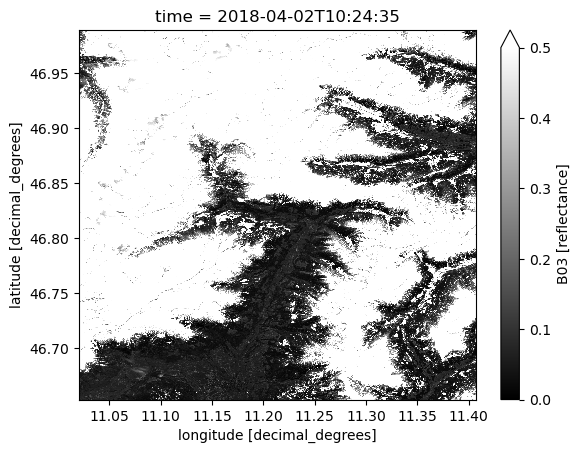

In [18]:
cube_s2rgb.B03.sel(time='2018-04-02T10:24:35.000000000').plot.imshow(vmin=0, vmax=0.5, cmap='gray')

Show the RGB image for the same date

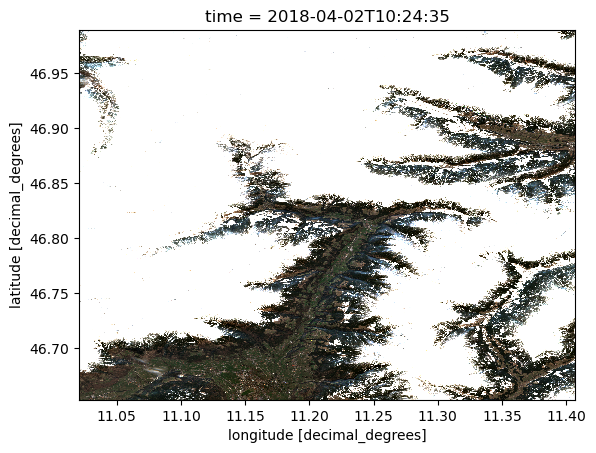

In [19]:
cube_s2rgb[['B04', 'B03', 'B02']].sel(time='2018-04-02T10:24:35.000000000').to_array().plot.imshow(vmin=0, vmax=0.3)

Show the cloud mask for the same date

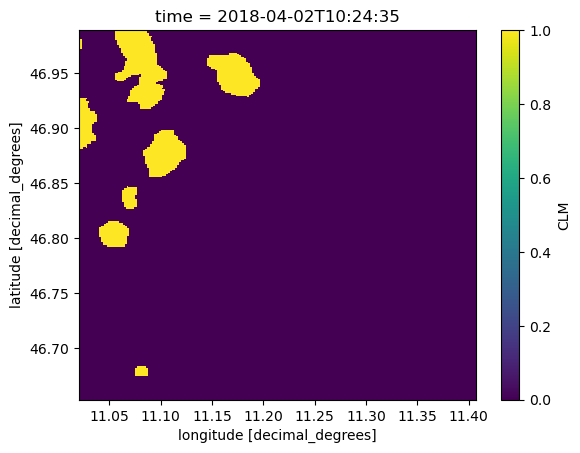

In [20]:
cube_s2rgb.CLM.sel(time='2018-04-02T10:24:35.000000000').plot.imshow()

Show a pixel time series for one band

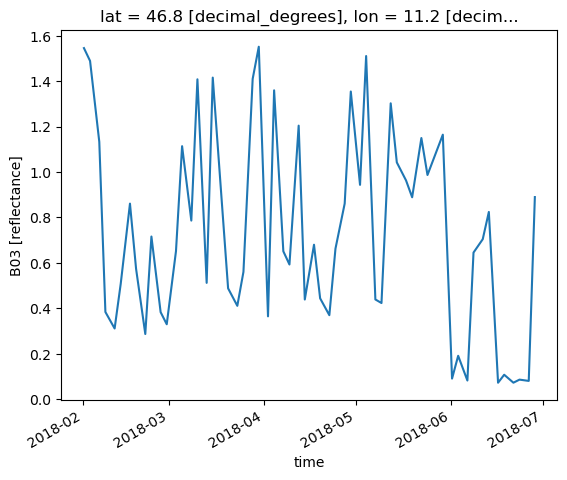

In [21]:
cube_s2rgb.B03.sel(lat=46.8, lon=11.2, method='nearest').plot()

### Create the snowmap data cube

After cloud masking, snow map can be obtained by thresholding the Normalized Difference Snow Index (NDSI) which is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We will therefore create a Sentinel-2 data cube with bands B03 (green), B11 (SWIR) and the cloud mask (CLM). To speed up the computation of the SCA we will set the resolution equal to 0.0018 degrees, which correspond roughly to 100 m. This resolution is generally enough to get reliable estimate of snow cover area over a catchment.

In [8]:
cube_config_s2snowmap = CubeConfig(
    dataset_name='S2L2A',
    band_names=['B03', 'B11', 'CLM'],
    bbox=bbox.tolist(),
    spatial_res=0.0018,
    time_range=[start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")],
    downsampling='BILINEAR'
)

/home/conda/master-asi-conae/315434deb1b1e05eacacc41e1b0529b1837100f46402a32041d77ba54ae6c5f3-20230213-125825-013239-74-edc-2022.10-14/lib/python3.9/site-packages/xcube_sh/config.py:248: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  time_tolerance = pd.to_timedelta(time_tolerance)


In [9]:
cube_s2snowmap = open_cube(cube_config_s2snowmap)
cube_s2snowmap

<xarray.Dataset>
Dimensions:    (time: 58, lat: 167, lon: 192, bnds: 2)
Coordinates:
  * lat        (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66 46.65
  * lon        (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36 11.37
  * time       (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T10:13:58
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-02-17T09:42:47.174581
    time_coverage_start:     2018-02-01T10:22:37+00:00
    time_coverage_end:       2018-06-28T10:13:58+00:00
    time_coverage_duration:  P146DT23H51M21S
    geospatial_lon_min:      11.020833333333357
    geospatial_lat_min:      46.653599378797765
    geospatial_lon_max:      11.366433333333356
    geospatial_lat_max:      46.95419937879777
    processing_level:        L2A

Compute the NDSI and add it to the cube

In [10]:
ndsi=(cube_s2snowmap.B03 - cube_s2snowmap.B11) / (cube_s2snowmap.B03 + cube_s2snowmap.B11)

ndsi.attrs['long_name']='Normalized Difference Snow Index'
ndsi.attrs['units']='unitless'

cube_s2snowmap['NDSI']=ndsi

Visualize an NDSI image for a specific date

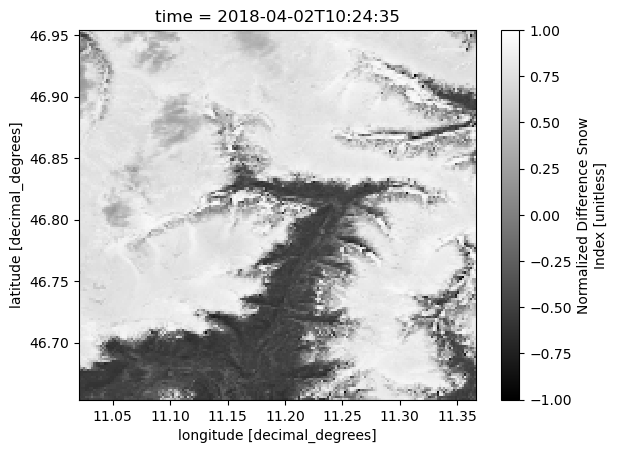

In [11]:
cube_s2snowmap.NDSI.sel(time='2018-04-02T10:24:35.000000000').plot.imshow(vmin=-1, vmax=1, cmap='gray')

Create the snow cover maps by setting a threshold equal to 0.4 on the NDSI

In [12]:
 cube_s2snowmap['snowmap'] = cube_s2snowmap.NDSI > 0.4

In [13]:
cube_s2snowmap

<xarray.Dataset>
Dimensions:    (time: 58, lat: 167, lon: 192, bnds: 2)
Coordinates:
  * lat        (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66 46.65
  * lon        (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36 11.37
  * time       (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T10:13:58
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
    B11        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
    CLM        (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
    NDSI       (time, lat, lon) float32 dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
    snowmap    (time, lat, lon) bool dask.array<chunksize=(1, 167, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    title:                   S2L2A Data Cube Subset
    history:                 [{'program': 'xcube_sh.chunkstore.SentinelHubChu...
    date_created:            2023-02-17T09:42:47.174581
    time_coverage_start:     2018-02-01T10:22:37+00:00
    time_coverage_end:       2018-06-28T10:13:58+00:00
    time_coverage_duration:  P146DT23H51M21S
    geospatial_lon_min:      11.020833333333357
    geospatial_lat_min:      46.653599378797765
    geospatial_lon_max:      11.366433333333356
    geospatial_lat_max:      46.95419937879777
    processing_level:        L2A

Add the cloud mask

In [14]:
cube_s2snowmap['snowmap'] = cube_s2snowmap.snowmap.where(cube_s2snowmap.CLM==0) 

Show a snow map (no snow = 0, snow = 1, cloud = NaN)

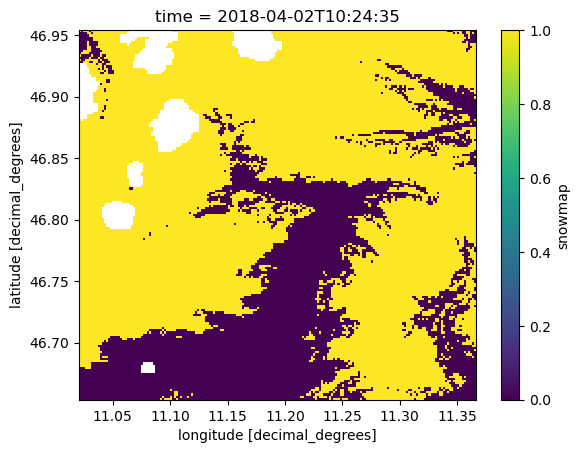

In [15]:
cube_s2snowmap.snowmap.sel(time='2018-04-02T10:24:35.000000000').plot.imshow()

### Catchment SCA time series

Mask with the catchment outline

In [16]:
cube_s2snowmap_masked = mask_dataset_by_geometry(cube_s2snowmap, catchment_outline.iloc[0].geometry)

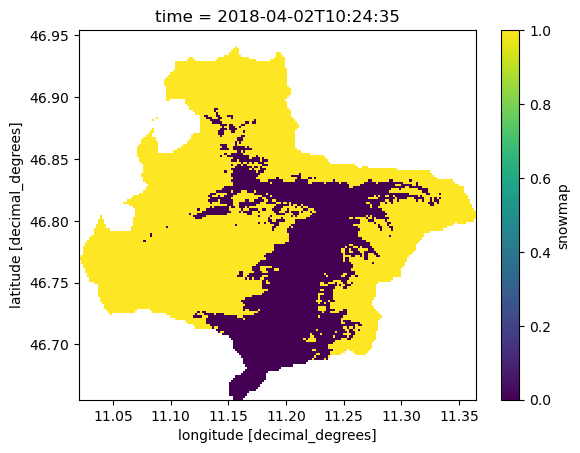

In [17]:
cube_s2snowmap_masked.snowmap.sel(time='2018-04-02T10:24:35.000000000').plot.imshow()

Compute the cloud percent in the catchment for each Sentinel-2 image

In [18]:
n_cloud = cube_s2snowmap_masked.CLM.sum(dim=['lat', 'lon'])
n_cloud_valid = cube_s2snowmap_masked.CLM.count(dim=['lat', 'lon'])

cube_s2snowmap_masked['cloud_percent'] = n_cloud / n_cloud_valid * 100
cube_s2snowmap_masked

<xarray.Dataset>
Dimensions:        (lat: 166, lon: 191, time: 58, bnds: 2)
Coordinates:
  * lat            (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66
  * lon            (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36
  * time           (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T1...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    B11            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    CLM            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    NDSI           (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    snowmap        (time, lat, lon) float64 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    cloud_percent  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2023-02-17T09:42:47.174581
    time_coverage_start:        2018-02-01T10:22:37+00:00
    time_coverage_end:          2018-06-28T10:13:58+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0018000000000000028
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0017999999999999822
    date_modified:              2023-02-17T09:43:16.744018

In order to get an accurate snow cover area estimation we want to keep only the Sentinel-2 images with a cloud percent in the catchment lower than 20%

In [19]:
cube_s2snowmap_masked = cube_s2snowmap_masked.sel(time=cube_s2snowmap_masked.cloud_percent < 20)

For the remaining image we can then estimate the snow cover area

In [20]:
n_snow = cube_s2snowmap_masked.snowmap.sum(dim=['lat', 'lon'])
n_snow_valid = cube_s2snowmap_masked.snowmap.count(dim=['lat', 'lon'])

cube_s2snowmap_masked['snow_percent'] = n_snow / n_snow_valid * 100

The snow and cloud percentage value can be represented in a pandas DataFrame and saved as csv

In [21]:
sca_ts = cube_s2snowmap_masked[['cloud_percent', 'snow_percent']].to_dataframe()
sca_ts

,cloud_percent,snow_percent
time,,
2018-02-08 10:11:53,14.107938,79.586701
2018-02-11 10:25:59,4.827089,74.475260
2018-02-13 10:15:59,18.384857,68.060348
2018-02-21 10:20:33,0.000000,71.934766
2018-02-28 10:10:21,12.765261,68.030633
2018-03-08 10:22:41,10.734870,85.508841
2018-03-20 10:10:21,11.095101,78.134669
2018-03-23 10:20:21,14.219282,69.458655
2018-03-25 10:15:11,4.466859,69.813520


In [22]:
sca_ts['snow_percent'].to_csv('s2_sca_ts_cloudfree.csv')

<AxesSubplot: xlabel='time'>

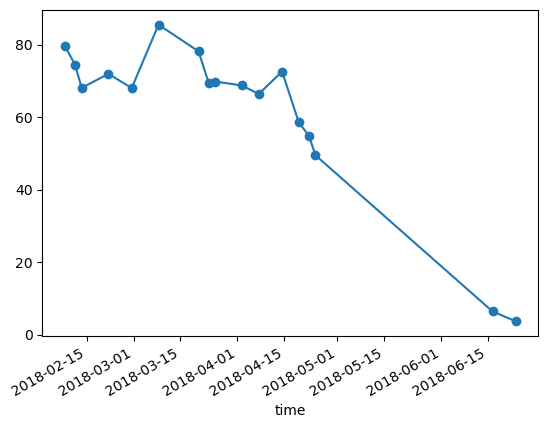

In [23]:
sca_ts['snow_percent'].plot(marker='o')

### Compare the evolution of SCA to runoff

In alpine catchment snow represent a major contribution to the runoff during the melting season. As a qualitative analysis we will plot the runoff time series for the selected catchment toghether with the SCA time series we derived from Sentinel-2. As soon as the SCA decreases due to melting, the snow melt contribution implies an increase of the runoff.

Load the runoff time series stored in the csv file:

In [24]:
dsc = pd.read_csv('ADO_DSC_ITH1_0025.csv', sep=',', index_col='Time', parse_dates=True)

In [25]:
dsc

,discharge_m3_s
Time,
1994-01-01 01:00:00,4.03
1994-01-02 01:00:00,3.84
1994-01-03 01:00:00,3.74
1994-01-04 01:00:00,3.89
1994-01-05 01:00:00,3.80
...,...
2021-07-17 02:00:00,NaN
2021-07-18 02:00:00,NaN
2021-07-19 02:00:00,NaN


Select the runoff time series accordingly with the time period we used to estimate the Sentinel-2 SCA

<AxesSubplot: xlabel='Time'>

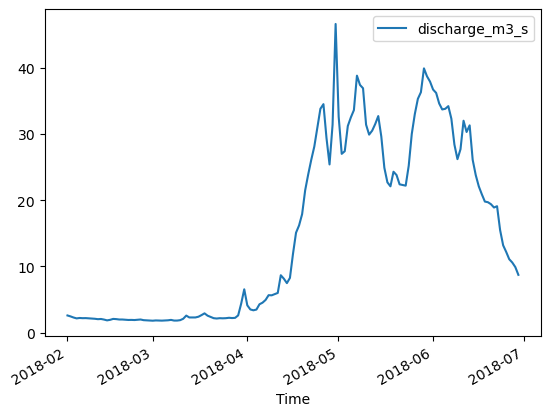

In [26]:
dsc = dsc.loc[start_date:end_date]
dsc.plot()

Plot the runoff (left axes, blue line) toghether with the Sentinel-2 SCA (right axes, orange line)

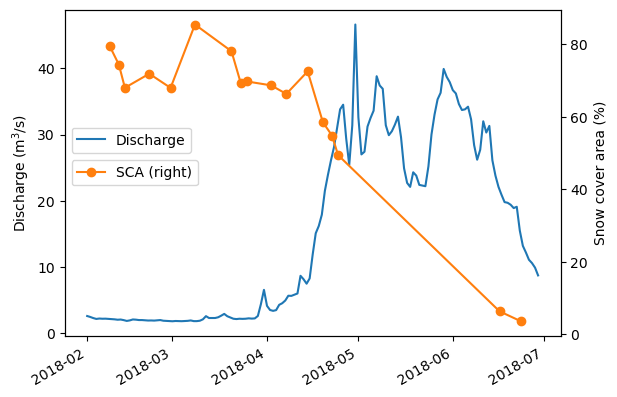

In [27]:
ax1 = dsc.discharge_m3_s.plot(label='Discharge', xlabel='', ylabel='Discharge (m$^3$/s)')
ax2 = sca_ts.snow_percent.plot(marker='o', secondary_y=True, label='SCA', xlabel='', ylabel='Snow cover area (%)')

ax1.legend(loc='center left', bbox_to_anchor=(0, 0.6))
ax2.legend(loc='center left', bbox_to_anchor=(0, 0.5))

plt.show()

In [14]:
cube_s2snowmap['snowmap'] = cube_s2snowmap.snowmap.where(cube_s2snowmap.CLM==0, 2) 

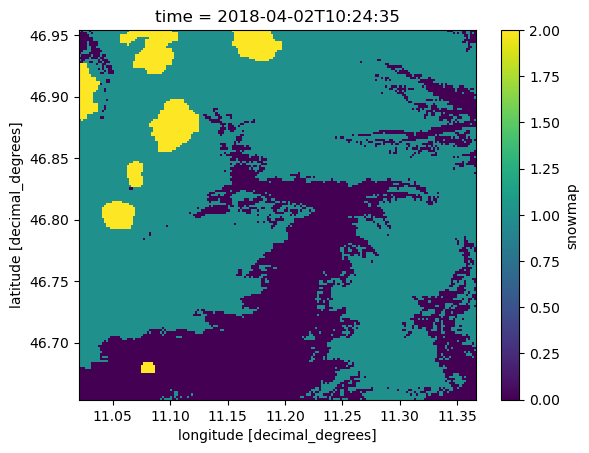

In [15]:
cube_s2snowmap.snowmap.sel(time='2018-04-02T10:24:35.000000000').plot.imshow()

In [16]:
cube_s2snowmap_masked = mask_dataset_by_geometry(cube_s2snowmap, catchment_outline.iloc[0].geometry, save_geometry_mask=True)
cube_s2snowmap_masked

<xarray.Dataset>
Dimensions:        (lat: 166, lon: 191, time: 58, bnds: 2)
Coordinates:
  * lat            (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66
  * lon            (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36
  * time           (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T1...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    B11            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    CLM            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    NDSI           (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    snowmap        (time, lat, lon) float64 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    geometry_mask  (lat, lon) bool dask.array<chunksize=(166, 191), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2023-02-17T09:40:08.516335
    time_coverage_start:        2018-02-01T10:22:37+00:00
    time_coverage_end:          2018-06-28T10:13:58+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0018000000000000028
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0017999999999999822
    date_modified:              2023-02-17T09:40:51.289454

In [17]:
cube_s2snowmap_masked['CLM'] = cube_s2snowmap_masked.CLM == 1
cube_s2snowmap_masked

<xarray.Dataset>
Dimensions:        (lat: 166, lon: 191, time: 58, bnds: 2)
Coordinates:
  * lat            (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66
  * lon            (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36
  * time           (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T1...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    B11            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    CLM            (time, lat, lon) bool dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    NDSI           (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    snowmap        (time, lat, lon) float64 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    geometry_mask  (lat, lon) bool dask.array<chunksize=(166, 191), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2023-02-17T09:40:08.516335
    time_coverage_start:        2018-02-01T10:22:37+00:00
    time_coverage_end:          2018-06-28T10:13:58+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0018000000000000028
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0017999999999999822
    date_modified:              2023-02-17T09:40:51.289454

In [18]:
n_cloud = cube_s2snowmap_masked.CLM.sum(dim=['lat', 'lon'])
n_valid = cube_s2snowmap_masked.geometry_mask.sum(dim=['lat', 'lon'])

cube_s2snowmap_masked['cloud_percent'] = n_cloud / n_valid * 100
cube_s2snowmap_masked

<xarray.Dataset>
Dimensions:        (lat: 166, lon: 191, time: 58, bnds: 2)
Coordinates:
  * lat            (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66
  * lon            (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36
  * time           (time) datetime64[ns] 2018-02-01T10:22:37 ... 2018-06-28T1...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(58, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    B11            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    CLM            (time, lat, lon) bool dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    NDSI           (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    snowmap        (time, lat, lon) float64 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    geometry_mask  (lat, lon) bool dask.array<chunksize=(166, 191), meta=np.ndarray>
    cloud_percent  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2023-02-17T09:40:08.516335
    time_coverage_start:        2018-02-01T10:22:37+00:00
    time_coverage_end:          2018-06-28T10:13:58+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0018000000000000028
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0017999999999999822
    date_modified:              2023-02-17T09:40:51.289454

In [19]:
cube_s2snowmap_masked = cube_s2snowmap_masked.sel(time=cube_s2snowmap_masked.cloud_percent < 20)
cube_s2snowmap_masked

<xarray.Dataset>
Dimensions:        (lat: 166, lon: 191, time: 17, bnds: 2)
Coordinates:
  * lat            (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66
  * lon            (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36
  * time           (time) datetime64[ns] 2018-02-08T10:11:53 ... 2018-06-23T1...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(17, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    B11            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    CLM            (time, lat, lon) bool dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    NDSI           (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    snowmap        (time, lat, lon) float64 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    geometry_mask  (lat, lon) bool dask.array<chunksize=(166, 191), meta=np.ndarray>
    cloud_percent  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2023-02-17T09:40:08.516335
    time_coverage_start:        2018-02-01T10:22:37+00:00
    time_coverage_end:          2018-06-28T10:13:58+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0018000000000000028
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0017999999999999822
    date_modified:              2023-02-17T09:40:51.289454

In [20]:
cube_s2snowmap_masked['snowmap'] = cube_s2snowmap_masked.snowmap == 1

In [21]:
n_snow = cube_s2snowmap_masked.snowmap.sum(dim=['lat', 'lon'])

cube_s2snowmap_masked['snow_percent'] = n_snow / (n_valid - n_cloud) * 100
cube_s2snowmap_masked

<xarray.Dataset>
Dimensions:        (lat: 166, lon: 191, time: 17, bnds: 2)
Coordinates:
  * lat            (lat) float64 46.95 46.95 46.95 46.95 ... 46.66 46.66 46.66
  * lon            (lon) float64 11.02 11.02 11.03 11.03 ... 11.36 11.36 11.36
  * time           (time) datetime64[ns] 2018-02-08T10:11:53 ... 2018-06-23T1...
    time_bnds      (time, bnds) datetime64[ns] dask.array<chunksize=(17, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    B03            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    B11            (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    CLM            (time, lat, lon) bool dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    NDSI           (time, lat, lon) float32 dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    snowmap        (time, lat, lon) bool dask.array<chunksize=(1, 166, 191), meta=np.ndarray>
    geometry_mask  (lat, lon) bool dask.array<chunksize=(166, 191), meta=np.ndarray>
    cloud_percent  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    snow_percent   (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                CF-1.7
    title:                      S2L2A Data Cube Subset
    history:                    [{'program': 'xcube_sh.chunkstore.SentinelHub...
    date_created:               2023-02-17T09:40:08.516335
    time_coverage_start:        2018-02-01T10:22:37+00:00
    time_coverage_end:          2018-06-28T10:13:58+00:00
    ...                         ...
    processing_level:           L2A
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.0018000000000000028
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.0017999999999999822
    date_modified:              2023-02-17T09:40:51.289454

In [22]:
sca_ts = cube_s2snowmap_masked[['cloud_percent', 'snow_percent']].to_dataframe()
sca_ts

,cloud_percent,snow_percent
time,,
2018-02-08 10:11:53,14.107938,79.586701
2018-02-11 10:25:59,4.827089,74.475260
2018-02-13 10:15:59,18.384857,68.060348
2018-02-21 10:20:33,0.000000,71.934766
2018-02-28 10:10:21,12.765261,68.030633
2018-03-08 10:22:41,10.734870,85.508841
2018-03-20 10:10:21,11.095101,78.134669
2018-03-23 10:20:21,14.219282,69.458655
2018-03-25 10:15:11,4.466859,69.813520
